In [47]:
from pathlib import Path
import turboflow.utils.file_utils as fle
import turboflow.utils.torch_utils as tch
import turboflow.utils.phy_utils as phy
import turboflow.utils.viz_utils as viz

import matplotlib.pyplot as plt

In [3]:
device = tch.get_device()
device = 'cpu'

Torch running on: cuda:0


In [4]:
results_dir = Path('..','recipes','turbo2D','single_images','results')
print(results_dir.exists())

True


In [6]:
from turboflow.dataloaders import Turb2DDataset

data_dir = Path('..','.cache','Turb2D.hdf5')
turb2D_train = Turb2DDataset(data_dir, time_idx=33, ds=4)
turb2D_test = Turb2DDataset(data_dir, time_idx=33, ds=1)

In [7]:
H = turb2D_test.res
shape_hr = turb2D_test.img_shape
X_hr, y_hr = turb2D_test[:]

L = turb2D_train.res
shape_lr = turb2D_train.img_shape
X_lr, y_lr = turb2D_train[:]

data_dict = {
    'hr' : {'X' : X_hr, 'y' : y_hr, 'R' : H, 'img_shape' : (H,H), 'data_shape' : (H,H,2)},
    'lr' : {'X' : X_lr, 'y' : y_lr, 'R' : L, 'img_shape' : (L,L), 'data_shape' : (L,L,2)}
}

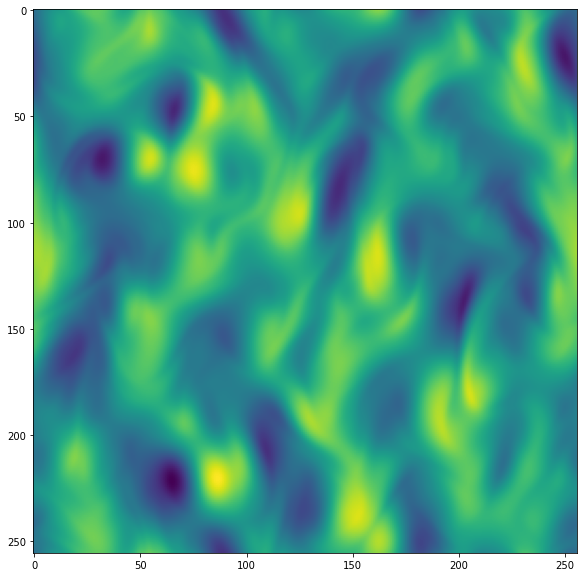

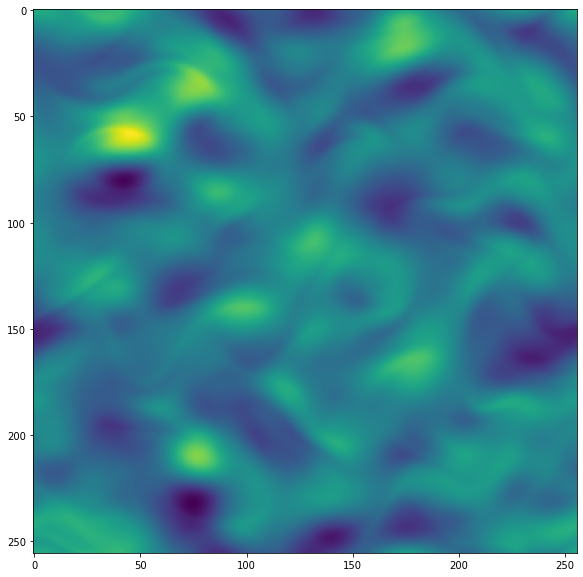

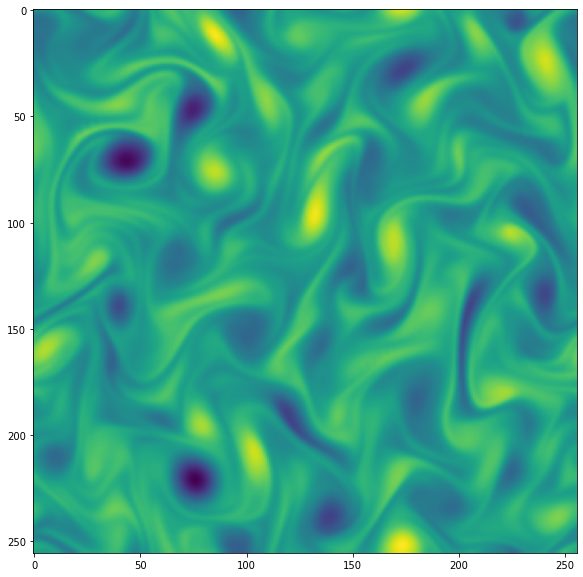

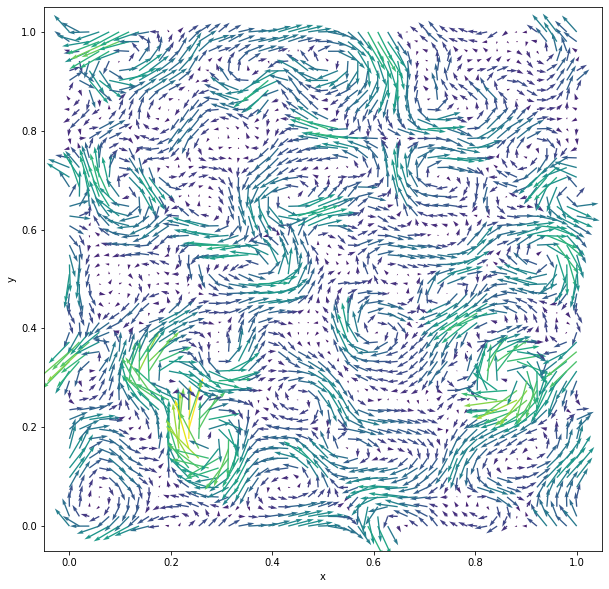

In [61]:
res = 'hr'
x = data_dict[res]['X'].reshape(data_dict[res]['data_shape'])[:,:,0].detach().numpy()
y = data_dict[res]['X'].reshape(data_dict[res]['data_shape'])[:,:,1].detach().numpy()
u = data_dict[res]['y'].reshape(data_dict[res]['data_shape'])[:,:,0].detach().numpy()
v = data_dict[res]['y'].reshape(data_dict[res]['data_shape'])[:,:,1].detach().numpy()
figsize = (10,10)

plt.figure(figsize=figsize)
plt.imshow(u)
plt.show()

plt.figure(figsize=figsize)
plt.imshow(v)
plt.show()

fig, ax = plt.subplots(figsize=figsize)
w = phy.compute_vorticity((x,y),(u,v), indexing='ij')
plt.imshow(w)

plt.show()

fig, ax = plt.subplots(figsize=figsize)
viz.plot_field((x, y), (u, v), step=5, scale=10, ax=ax)
plt.show()

In [79]:
for f in results_dir.glob('*.pkl'):
    print(f)

../recipes/turbo2D/single_images/results/Turb2D-RFF:512.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:4096.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:4096-softDF-Sfun:1e-2.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:4096-hardDF-Sfun-Psmooth.pkl
../recipes/turbo2D/single_images/results/Turb2D-MLPvanilla.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:4096-softDF-Sfun.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:4096-softDF.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:2048.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:4096-hardDF-Sfun.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:4096-softDF-Sfun:1e-3.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:4096-hardDF-Sfun-PsmoothHR.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:256.pkl
../recipes/turbo2D/single_images/results/Turb2D-RFF:1024.pkl


Processing MLPvanilla
Processing RFF
Processing RFF
Processing RFF:1024
Processing RFF:2048
Processing RFF:4096


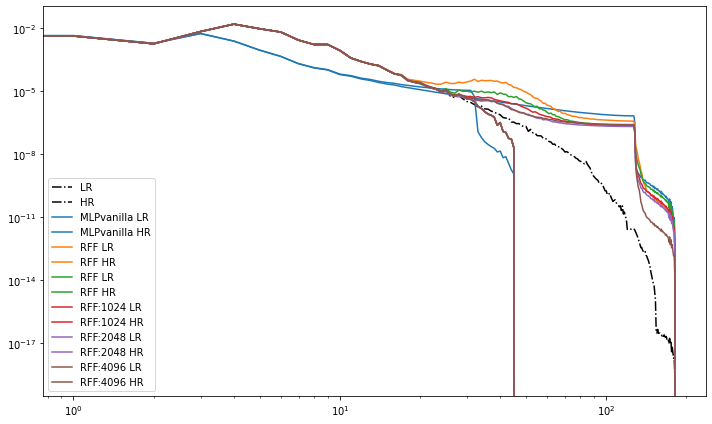

In [78]:
files = [
    'Turb2D-MLPvanilla.pkl',
    'Turb2D-RFF:256.pkl',
    'Turb2D-RFF:512.pkl',
    'Turb2D-RFF:1024.pkl',
    'Turb2D-RFF:2048.pkl',
    'Turb2D-RFF:4096.pkl',
]


plt.figure(figsize=(10,6))

spec_lr = phy.energy_spectrum(y_lr.view(data_dict['lr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
spec_hr = phy.energy_spectrum(y_hr.view(data_dict['hr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
plt.loglog(spec_lr, 'k-.', label=f'LR')
plt.loglog(spec_hr, 'k-.', label=f'HR')
    
for f, file in enumerate(files):
    results_dict = fle.load_obj(Path(results_dir,file))
    results = results_dict['results']
    name = results_dict['model']['name']
    path = results_dict['path_to_model']
    print(f'Processing {name}')
    
    from turboflow.models.phyrff_hard import plDivFreeRFFNet
    
    model = plDivFreeRFFNet.load_from_checkpoint(path).eval().to(device)
    y_hat_lr = model(data_dict['lr']['X'].to(device))[0]
    y_hat_hr = model(data_dict['hr']['X'].to(device))[0]
    
    spec_lr = phy.energy_spectrum(y_hat_lr.view(data_dict['lr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
    spec_hr = phy.energy_spectrum(y_hat_hr.view(data_dict['hr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
    
    plt.loglog(spec_lr, f'C{f}', label=f'{name} LR')
    plt.loglog(spec_hr, f'C{f}', label=f'{name} HR')
    
    
plt.legend()
plt.tight_layout()
plt.show()

Processing RFF:4096
Processing RFF:4096-softDF


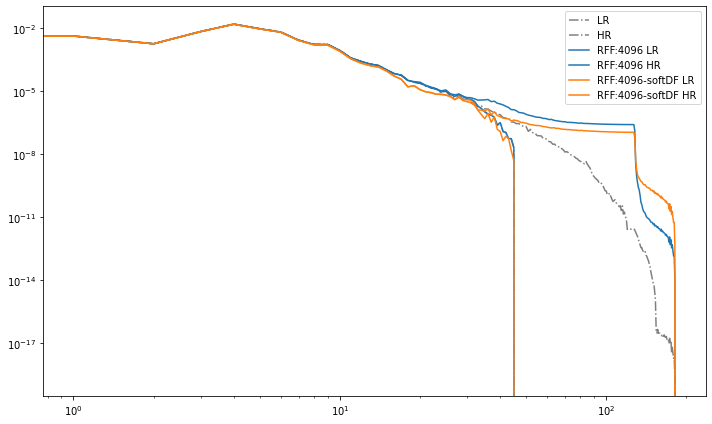

In [68]:
files = [
    'Turb2D-RFF:4096.pkl',
    'Turb2D-RFF:4096-softDF.pkl',
]


plt.figure(figsize=(10,6))

spec_lr = phy.energy_spectrum(y_lr.view(data_dict['lr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
spec_hr = phy.energy_spectrum(y_hr.view(data_dict['hr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
plt.loglog(spec_lr, 'k-.', label=f'LR', alpha=0.5)
plt.loglog(spec_hr, 'k-.', label=f'HR', alpha=0.5)
    
for f, file in enumerate(files):
    results_dict = fle.load_obj(Path(results_dir,file))
    results = results_dict['results']
    name = results_dict['model']['name']
    path = results_dict['path_to_model']
    print(f'Processing {name}')
    
    from turboflow.models.phyrff_hard import plDivFreeRFFNet
    
    model = plDivFreeRFFNet.load_from_checkpoint(path).eval().to(device)
    y_hat_lr = model(data_dict['lr']['X'].to(device))[0]
    y_hat_hr = model(data_dict['hr']['X'].to(device))[0]
    
    spec_lr = phy.energy_spectrum(y_hat_lr.view(data_dict['lr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
    spec_hr = phy.energy_spectrum(y_hat_hr.view(data_dict['hr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
    
    plt.loglog(spec_lr, f'C{f}', label=f'{name} LR')
    plt.loglog(spec_hr, f'C{f}', label=f'{name} HR')
    
    
plt.legend()
plt.tight_layout()
plt.show()

Processing RFF:4096
Processing RFF:4096-softDF
Processing RFF:4096-softDF-Sfun:1e-3
Processing RFF:4096-softDF-Sfun:1e-2
Processing RFF:4096-softDF-Sfun:1e-1


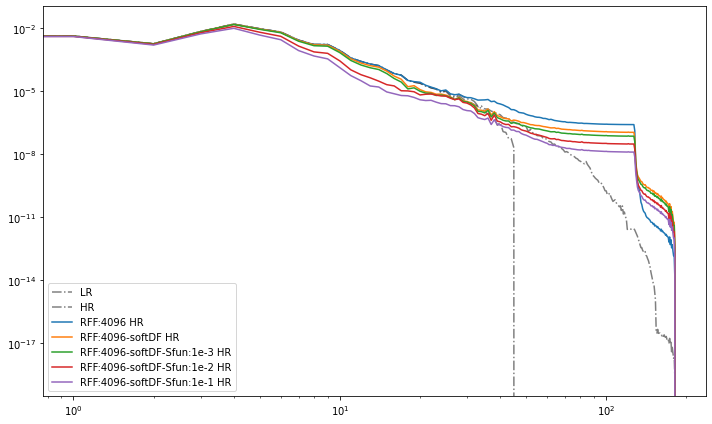

In [81]:
files = [
    'Turb2D-RFF:4096.pkl',
    'Turb2D-RFF:4096-softDF.pkl',
    'Turb2D-RFF:4096-softDF-Sfun:1e-3.pkl',
    'Turb2D-RFF:4096-softDF-Sfun:1e-2.pkl',
    'Turb2D-RFF:4096-softDF-Sfun:1e-1.pkl'
]


plt.figure(figsize=(10,6))

spec_lr = phy.energy_spectrum(y_lr.view(data_dict['lr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
spec_hr = phy.energy_spectrum(y_hr.view(data_dict['hr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
plt.loglog(spec_lr, 'k-.', label=f'LR', alpha=0.5)
plt.loglog(spec_hr, 'k-.', label=f'HR', alpha=0.5)
    
for f, file in enumerate(files):
    results_dict = fle.load_obj(Path(results_dir,file))
    results = results_dict['results']
    name = results_dict['model']['name']
    path = results_dict['path_to_model']
    print(f'Processing {name}')
    
    from turboflow.models.phyrff_hard import plDivFreeRFFNet
    
    model = plDivFreeRFFNet.load_from_checkpoint(path).eval().to(device)
    y_hat_lr = model(data_dict['lr']['X'].to(device))[0]
    y_hat_hr = model(data_dict['hr']['X'].to(device))[0]
    
    spec_lr = phy.energy_spectrum(y_hat_lr.view(data_dict['lr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
    spec_hr = phy.energy_spectrum(y_hat_hr.view(data_dict['hr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
    
#     plt.loglog(spec_lr, f'C{f}', label=f'{name} LR')
    plt.loglog(spec_hr, f'C{f}', label=f'{name} HR')
    
    
plt.legend()
plt.tight_layout()
plt.show()

Processing RFF:4096
Processing RFF:4096-softDF
Processing RFF:4096-hardDF-Sfun
Processing RFF:4096-hardDF-Sfun-PsmoothHR


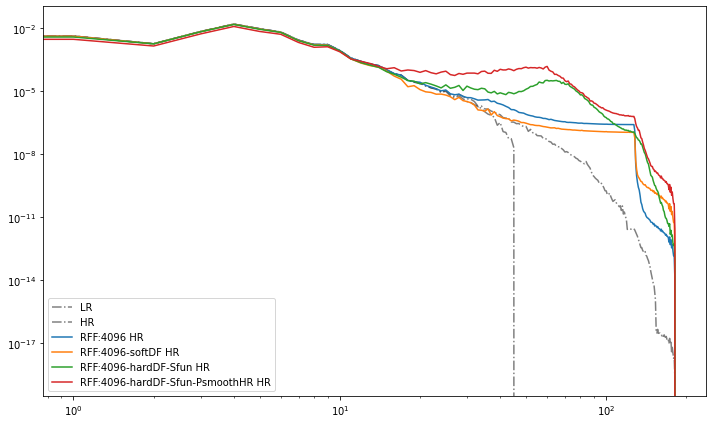

In [75]:
files = [
    'Turb2D-RFF:4096.pkl',
    'Turb2D-RFF:4096-softDF.pkl',
    'Turb2D-RFF:4096-hardDF-Sfun.pkl',
    'Turb2D-RFF:4096-hardDF-Sfun-PsmoothHR.pkl'
]


plt.figure(figsize=(10,6))

spec_lr = phy.energy_spectrum(y_lr.view(data_dict['lr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
spec_hr = phy.energy_spectrum(y_hr.view(data_dict['hr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
plt.loglog(spec_lr, 'k-.', label=f'LR', alpha=0.5)
plt.loglog(spec_hr, 'k-.', label=f'HR', alpha=0.5)
    
for f, file in enumerate(files):
    results_dict = fle.load_obj(Path(results_dir,file))
    results = results_dict['results']
    name = results_dict['model']['name']
    path = results_dict['path_to_model']
    print(f'Processing {name}')
    
    from turboflow.models.phyrff_hard import plDivFreeRFFNet
    
    model = plDivFreeRFFNet.load_from_checkpoint(path).eval().to(device)
    y_hat_lr = model(data_dict['lr']['X'].to(device))[0]
    y_hat_hr = model(data_dict['hr']['X'].to(device))[0]
    
    spec_lr = phy.energy_spectrum(y_hat_lr.view(data_dict['lr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
    spec_hr = phy.energy_spectrum(y_hat_hr.view(data_dict['hr']['data_shape']).permute(2,0,1))[0].detach().cpu().numpy()
    
#     plt.loglog(spec_lr, f'C{f}', label=f'{name} LR')
    plt.loglog(spec_hr, f'C{f}', label=f'{name} HR')
    
    
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
results_dict = fle.load_obj(Path(results_dir,'Turb2D-RFF:4096-hardDF-Sfun.pkl'))
results_dict

{'path_to_model': '/home/dicarlo_d/Documents/Code/TurboSuperResultion/recipes/turbo2D/single_images/.torch_checkpoints/Turb2D-RFF:4096-hardDF-Sfun-epoch=1299-val_loss=0.00-v1.ckpt',
 'model': "do_divfree":         True
 "do_rff":             True
 "lam_div":            0
 "lam_pde":            0.0001
 "lam_reg":            0
 "lam_sfn":            0.0001
 "lam_spec":           0
 "mlp_last_actfn":     tanh
 "mlp_layers_dim":     256
 "mlp_layers_num":     3
 "name":               RFF:4096-hardDF-Sfun
 "rff_num":            4096
 "rff_scale":          10
 "sfn_min_x":          0.00784314
 "sfn_num_centers":    64
 "sfn_num_increments": 3
 "sfn_patch_dim":      30,
 'name': 'Turb2D-RFF:4096-hardDF-Sfun',
 'results': [{'test/metrics/reconstruction': 0.0021447124890983105,
   'test/metrics/angular_degree': 2.104764938354492,
   'test/metrics/log_err_specturm': 74.8340072631836}],
 'tb_trial_id': '/home/dicarlo_d/Documents/Code/TurboSuperResultion/recipes/turbo2D/single_images/version_18'}

In [36]:
for f, file in enumerate(files):
    results_dict = fle.load_obj(Path(results_dir,file))
    results = results_dict['results']
    print(file)
    print(file, '\t%1.4f\t%1.4f\t%1.4f' %
          (results[0]['test/metrics/reconstruction'],
           results[0]['test/metrics/angular_degree'],
           results[0]['test/metrics/log_err_specturm']))

Turb2D-RFF:4096.pkl
Turb2D-RFF:4096.pkl 	0.0002	0.4689	43.9053
Turb2D-RFF:4096-softDF.pkl
Turb2D-RFF:4096-softDF.pkl 	0.0005	0.8827	59.7952
Turb2D-RFF:4096-softDF-Sfun.pkl
Turb2D-RFF:4096-softDF-Sfun.pkl 	0.0005	0.8705	58.8255
Turb2D-RFF:4096-hardDF-Sfun.pkl
Turb2D-RFF:4096-hardDF-Sfun.pkl 	0.0021	2.1048	74.8340
Turb2D-RFF:4096-hardDF-Sfun-Psmooth.pkl
Turb2D-RFF:4096-hardDF-Sfun-Psmooth.pkl 	0.0220	6.7666	86.3972
Turb2D-RFF:4096-hardDF-Sfun-PsmoothHR.pkl
Turb2D-RFF:4096-hardDF-Sfun-PsmoothHR.pkl 	0.0114	4.8220	94.2923
